## Imports

In [4]:
import numpy as np
import math
import datascience
import scipy
from datascience import *
from scipy import *
from scipy.signal import find_peaks, find_peaks_cwt, savgol_filter
import sklearn
from sklearn.metrics import mean_absolute_error
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.rcParams["figure.figsize"] = (10,7)
import time

## Data
`Peak_Interval_List.csv` and `Ig110postbakemap9476.CSV` from
Graphite Raman Mapping (Project 31) on Box.

x,y
500,1.11038
500.137,0.985766
500.274,0.951698
500.411,0.957243
500.547,0.893833
500.684,0.883336
500.821,0.872838
500.958,0.889714
501.095,0.849866
501.232,0.835878


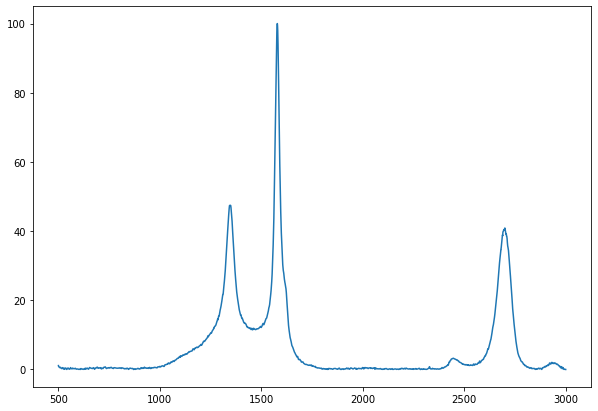

In [5]:
peak_intervals = Table().read_table("new_peak_list.csv")
sample_spectrum = Table().read_table("JQ2a2_16.csv")
#sample_spectrum = Table().read_table("Ig110postbakemap9476.CSV")
plots.plot(sample_spectrum.column("x"), sample_spectrum.column("y"))
sample_spectrum

In [6]:
peak_intervals

Peak Name,Peak Number,Optional?,Min Bound X,Max Bound X
Pre-D,1,Yes,1000,1320
D,2,No,1340,1360
D-G shoulder,3,Yes,1370,1550
G,4,No,1560,1600
D' shoulder,5,No,1600,1630
T+D,6,Yes,2300,2500
G'_3Da,7,No,2640,2690
G'_2D,8,No,2680,2720
G'_3DB,9,No,2700,2740
D'+D,10,No,2850,2950


## Driver Function
`spectrum`: table with two columns: x and y <br>  
`num_peaks`: int, how many peaks to fit with <br>  
`baseline_deg`: degree of polynomial to fit baseline with  <br>  
`baseline_tol`: tolerance to stop baseline iteration  <br>  
`peak_type`: lorentz/gaussian, later add option to choose others (examples in the matlab, should be able to express with the same parameters) <br>  
`error`: MAE, MSE, etc. <br>  
`tolerance`: to within what error should we fit <br>  
`num_iterations`: how many iterations should we go through <br>  
`window_len`: length of savitsky-golay filter window <br>  
`polyorder`: order of polynomial to fit samples in savitsky-golay

In [7]:
lambda_1 = 0.05
lambda_2 = 0.05

In [22]:
def fit_spectrum(spectrum, num_peaks, baseline_deg, baseline_tol, peak_type, error_type, tolerance, num_iterations, window_len, polyorder):
    start_time = time.time() # unit: seconds
    # Restrict data x to 500-3000
    restricted_spectrum = spectrum.where("x", are.between_or_equal_to(500, min(3000, max(spectrum.column("x")))))
    # Smooth signal with Savitsky-Golay filter
    smoothed_y = scipy.signal.savgol_filter(restricted_spectrum.column("y"), window_len, polyorder)
    smoothed_spectrum = Table().with_columns("x", restricted_spectrum.column("x"), "y", smoothed_y)
    # Remove baseline
    spectrum_baseline_removed = remove_baseline(smoothed_spectrum, baseline_deg, baseline_tol)
    # Normalize spectrum
    normalized_y = ((spectrum_baseline_removed.column("y") - min(spectrum_baseline_removed.column("y")))
                    / (max(spectrum_baseline_removed.column("y")) - min(spectrum_baseline_removed.column("y"))))
    normalized_spectrum = Table().with_columns("x", spectrum_baseline_removed.column("x"), "y", normalized_y)
    # Identify peaks
    # check peak interval - edit num_peaks
    detected_peaks = detect_peaks(normalized_spectrum, num_peaks)
    # Reconstruct spectra
    peaks = create_peaks(peak_type, detected_peaks)

    # Create loss function that we will optimize
    def error(guess_array):
        # first num_peaks elems are amp, next are cen, next are wid
        amp = guess_array[0:num_peaks]
        cen = guess_array[num_peaks:2*num_peaks]
        wid = guess_array[2*num_peaks:3*num_peaks]
        guess_peaks = Table().with_columns("Peak #", range(num_peaks),
                                          "amp", amp, "cen", cen, "wid", wid)
        reconstructed = reconstruct_spectrum(normalized_spectrum, guess_peaks)
        # choose error
        if error_type == "MAE":
            e = sklearn.metrics.mean_absolute_error(normalized_spectrum.column("y"), reconstructed)
        elif error_type == "MSE":
            e = sklearn.metrics.mean_squared_error(normalized_spectrum.column("y"), reconstructed)
        elif error_type == "MAPE":
            e = sklearn.metrics.mean_absolute_percentage_error(normalized_spectrum.column("y"), reconstructed)
        elif error_type == "RMSPE":
            e = RMSPE(normalized_spectrum.column("y"), reconstructed)
        else:
            raise Exception("Error type not supported")
        print(e)
        return e
        return e #+ lambda_1 * (1 if guess_array[num_peaks + 8] < guess_array[num_peaks + 7] else 0) + lambda_2 * abs(guess_array[6] / guess_array[8] - 0.5)
    
    # change this from numpy appending to normal python list operations
    initial_guess = np.append(np.append(peaks.column("amp"), peaks.column("cen").astype(int)), peaks.column("wid"))

    # create bounds
    amp_bounds = [(0.0001, 300) for i in range(num_peaks)]
    min_x = peak_intervals.column("Min Bound X")
    max_x = peak_intervals.column("Max Bound X")
    cen_bounds = [(min_x[i], max_x[i]) for i in range(num_peaks)]
    wid_bounds = [(0.0001, 400) for i in range(num_peaks)]
    bounds = amp_bounds + cen_bounds + wid_bounds
    
    # ensure center of peak 9 > peak 8
    cons1 = {"type": "ineq", "fun": lambda arr: arr[num_peaks + 8] - arr[num_peaks + 7]}
    # upper bound for peak 7 : peak 9 (amplitude)
    cons2 = {"type": "ineq", "fun": lambda arr: arr[6] / arr[8] - 0.45}
    # lower bound for peak 7 : peak 9 (amplitude)
    cons3 = {"type": "ineq", "fun": lambda arr: -(arr[6] / arr[8]) + 0.55}
    constraints = [cons1, cons2, cons3]
    constraints_test = [cons1]
    
    initial_guess = np.asarray([
        7.37908,
34.97015,
3.65915,
36.15784,
4.22964,
2.89295,
5.91514,
17.67787,
10.7548,
2.4001,
                                
                                
                                1275.74783,
1348.01504,
1493.83166,
1581.71285,
1620.46057,
2456.79433,
2666.37302,
2694.74791,
2721.62489,
2940.27771,
                                
                                
                                
                                215.7532,
44.50159,
92.21057,
23.70187,
24.28155,
67.71584,
59.9331,
47.47378,
40.57773,
58.14838])
    
    initial_guess_better = np.asarray([
        
    ])
    
    #original minimize call - commenting out for testing others
    result_full = scipy.optimize.minimize(error, initial_guess, bounds=bounds, tol=tolerance,
                                     options={"maxiter": num_iterations})
    
    # trust-const implementation
    #result = scipy.optimize.minimize(error, initial_guess, bounds=bounds, tol=None,
    #                                options={"maxiter": num_iterations, "verbose": 2}, constraints=constraints_test,
    #                                method = "trust-constr")
    
    # nelder-mead implementation
    #result = scipy.optimize.minimize(error, initial_guess, bounds=bounds, tol=None,
    #                                 options={"maxiter": num_iterations},
    #                                    method = "Nelder-Mead")
    
    #print("Status: ", result.status)
    #print("Execution time: ", result.execution_time)
    #print("Solution:", result.x)
    #print("Message: ", result.message)
    #final_error = error(result.x)
    
    result = result_full.x
    
    # plot result
    result_matrix = Table().with_columns("Peak #", np.arange(num_peaks),
                                        "amp", result[0:num_peaks],
                                        "cen", result[num_peaks:2*num_peaks],
                                        "wid", result[2*num_peaks:3*num_peaks])
    print(result_matrix)
    reconstructed_y = reconstruct_spectrum(normalized_spectrum, result_matrix)
    
    guess_and_real = Table().with_columns("Real", normalized_y, "Reconstructed", reconstructed_y, "x", normalized_spectrum.column("x"))
    #guess_and_real.plot("x")
    
    
    # Temporary test code
    # Plotting individual peaks
    
    test_plot = guess_and_real
    #for i in range(num_peaks):
    #    parameters_i = result_matrix.row(i)
    #    amp_i = parameters_i.item("amp")
    #    cen_i = parameters_i.item("cen")
    #    wid_i = parameters_i.item("wid")
    #    peak_i = [lorentz(x, amp_i, cen_i, wid_i) for x in normalized_spectrum.column("x")]
    #    test_plot = test_plot.with_columns(f"Peak {i}", peak_i)
    # test_plot.plot("x")
    plots.plot(test_plot.column("x"), test_plot.column("Real"), label="Real")
    plots.plot(test_plot.column("x"), test_plot.column("Reconstructed"), label="Reconstructed")
    #for i in range(num_peaks):
    #    plots.plot(test_plot.column("x"), test_plot.column(f"Peak {i}"), label=f"Peak {i + 1}")
    plots.legend()
    
    
    
    end_time = time.time()
    print(f"Program runtime (minutes):  {(end_time - start_time) / 60}")
    
    print(error(result))
    return result_full

In [9]:
# returns an array the same length as x
# fits points in spectrum x to polynomial of degree deg
# change tol to be for error between previous line and new line

# save old coeffs to compare polynomials on the same set of x values -> above/below tol
# try a value for tol - set a default
# doesn't really matter which error we use - use msre with a tolerance of 1% (or MRE)
# initial guess: fit line
# full=True allows us to access sum of squared residuals of the fit as well
def baseline(spectrum, deg, tol):
    s = spectrum
    e = float('inf')
    old_coef = None
    nrows = 0
    while(e > tol):
        # adding this condition to hopefully make stuff better
        if spectrum.num_rows == 0:
            break;
        print(e)
        # create fit line w/ np.polyfit & turn into a function w/ polyn
        coef = np.polyfit(spectrum.column("x"), spectrum.column("y"), deg, full=False)
        polyn = make_polynomial(coef, deg)
        # re-fit line to remaining points
        
        baseline_fit = spectrum.apply(polyn, "x")
        #plots.plot(spectrum.column("x"), spectrum.column("y"))
        
        #plots.plot(spectrum.column("x"), baseline_fit)
        # do error b/t previous line
        if type(old_coef) != type(None):
            #e = sklearn.metrics.mean_absolute_error(baseline_fit, spectrum.apply(make_polynomial(old_coef, deg), "y"))
            e = RMSPE(baseline_fit, spectrum.apply(make_polynomial(old_coef, deg), "x"))
        # remove any points above fit line
        spectrum = spectrum.with_column("baseline", baseline_fit)
        print(spectrum)
        wanted_indices_bool = spectrum.column("y") <= spectrum.column("baseline")
        wanted_indices = [i for i in range(len(wanted_indices_bool)) if wanted_indices_bool[i]]
        spectrum = spectrum.take(wanted_indices)
        # repeat until fitting error < tol or # points doesn't change
        old_coef = coef
        print("spectrum rows ", spectrum.num_rows)
        print("nrows ", nrows)
        # added condition so every single point isn't destroyed
        if abs(nrows - spectrum.num_rows) < 75:
            break
        if spectrum.num_rows == nrows:
            print("nrows exit")
            break
        nrows = spectrum.num_rows
    # changed spectrum
    baseline_ret = s.apply(polyn, "x")
    #plots.plot(s.column("x"), s.column("y"))
    #plots.plot(s.column("x"), baseline_ret)
    return baseline_ret

In [10]:
# takes in a table and returns a table w/ same columns & dimensions
def remove_baseline(spectrum, deg, tol):
    bl = baseline(spectrum, deg, tol)
    return Table().with_columns("x", spectrum.column("x"), "y", spectrum.column("y") - bl)

In [11]:
# returns a single-variable polynomial function of degree deg from coefficients coef
def make_polynomial(coef, deg):
    # takes in an array of x values and returns an array of y values of the same dimension
    def polyn(x):
        y = 0
        for i in range(deg + 1):
            y += pow(x, deg - i) * coef[i]
        return y
    return polyn

In [12]:
# returns an array with num_peaks x-values set to the midpoint of their bounds
# add option to remove peaks that are not required for lower num_peaks
def detect_peaks(spectra, num_peaks):
    midpoints = (peak_intervals.column("Min Bound X") + peak_intervals.column("Max Bound X")) / 2
    return midpoints

In [13]:
# returns a matrix of initial guesses
# dimensions 4 x num_peaks (4 = num parameters - x)
def create_peaks(peak_type, detected_peaks):
    if peak_type == "lorentz":
        parameter_matrix = Table(["Peak #", "amp", "cen", "wid"])
        for i in np.arange(len(detected_peaks)):
            amp = guess_amp()
            cen = detected_peaks[i]
            wid = guess_wid()
            parameter_matrix.append([i, amp, cen, wid])
        return parameter_matrix
    elif peak_type == "gaussian":
        return False

In [14]:
def guess_amp():
    return 5

In [15]:
def guess_wid():
    return 10

In [16]:
# x - values where the function is calculated
# y_0 - baseline
# amp - area
# cen - peak's center position
# wid - controls full width half maximum of the function
def lorentz(x, amp, cen, wid):
    return (amp/np.pi)*(wid / ((x - cen) ** 2 + wid ** 2))

In [17]:
# x - values where the function is calculated
# y_0 - baseline
# height - height of peak
# center - center of peak
# std - standard deviation
def gaussian(x, y_0, amp, cen, wid):
    std=wid/2.355
    return (amp / (std * np.sqrt(2*np.pi))) * (np.e ** -(((x - center) ** 2)) / 2 * std ** 2) + y_0

In [18]:
# returns an array of y values for each x value in spectrum. y values obtained using peak_parameters
def reconstruct_spectrum(spectrum, peak_parameters):
    def reconstruct_sum(x):
        peaks = peak_parameters.with_columns("x", [x for i in range(peak_parameters.num_rows)])
        sum_peaks = peaks.apply(lorentz, "x", "amp", "cen", "wid")
        return np.sum(sum_peaks)
    reconstructed = [reconstruct_sum(x) for x in spectrum.column("x")]
    return reconstructed

In [19]:
def RMSPE(y_true, y_pred):
    EPSILON = 1e-10
    return (np.sqrt(np.mean(np.square((y_true + EPSILON - y_pred) / y_true + EPSILON)))) * 100

## Demo

fit_spectrum(spectrum, num_peaks, baseline_deg, baseline_tol, peak_type, error_type, tolerance, num_iterations, window_len, polyorder)

In [ ]:
x = fit_spectrum(sample_spectrum, 10, 1, 0.01, "lorentz", "MAPE", None, 10000000, 27, 2)

inf
x       | y        | baseline
500     | 1.02208  | 6.02185
500.137 | 0.999696 | 6.02187
500.274 | 0.977967 | 6.02189
500.411 | 0.956895 | 6.02191
500.547 | 0.936481 | 6.02193
500.684 | 0.916725 | 6.02196
500.821 | 0.897628 | 6.02198
500.958 | 0.879188 | 6.022
501.095 | 0.861407 | 6.02202
501.232 | 0.844284 | 6.02205
... (18261 rows omitted)
spectrum rows  13742
nrows  0
inf
x       | y        | baseline
500     | 1.02208  | 0.823651
500.137 | 0.999696 | 0.823669
500.274 | 0.977967 | 0.823688
500.411 | 0.956895 | 0.823706
500.547 | 0.936481 | 0.823725
500.684 | 0.916725 | 0.823743
500.821 | 0.897628 | 0.823761
500.958 | 0.879188 | 0.82378
501.095 | 0.861407 | 0.823798
501.232 | 0.844284 | 0.823817
... (13732 rows omitted)
spectrum rows  9610
nrows  13742
534.7249210521891
x       | y        | baseline
501.505 | 0.812011 | 0.317741
501.642 | 0.796862 | 0.31774
501.779 | 0.782371 | 0.317738
501.916 | 0.774402 | 0.317736
502.053 | 0.762265 | 0.317735
502.189 | 0.750042 | 0.317733
502.3

0.02391422409986286
0.023914224099532942
0.023914224099037783
0.023466334037803786
0.023466334036190938
0.023466334034388484
0.023466334035521876
0.023466334034993885
0.02346633403689371
0.023466334039362192
0.02346633403748009
0.023466334036897105
0.02346633403717108
0.023466334040448504
0.023466334037798037
0.023466334037822403
0.023466334037834935
0.023466334038558207
0.023466334038201198
0.023466334037808814
0.023466334037726553
0.023466334037947397
0.02346633403820783
0.02346633403778678
0.023466334037862743
0.023466334038261857
0.023466334037862992
0.023466334039418463
0.02346633403796301
0.023466334037842308
0.02346633403799885
0.023466334038595143
0.023466334038262784
0.023466334037769498
0.02182155140516303
0.021821551403618453
0.021821551401767787
0.02182155140299543
0.021821551402834212
0.021821551404991705
0.021821551406504033
0.02182155140475427
0.021821551404166143
0.021821551404444833
0.02182155140590187
0.021821551405156576
0.021821551405185394
0.021821551405207095
0.02

0.01211246818908042
0.01211246818913334
0.012112468189129961
0.01211246818925804
0.012112468188827797
0.01211246818939196
0.012112468189080424
0.012112468189244087
0.01211246819042664
0.012112468189703032
0.012112468189080424
0.011452963246074296
0.011452963246675659
0.011452963247684605
0.01145296324637272
0.011452963246276494
0.011452963244970268
0.0114529632468925
0.011452963247315536
0.01145296324621223
0.01145296324677877
0.011452963246638168
0.011452963246114093
0.011452963246195347
0.011452963246018483
0.01145296323980794
0.011452963246200607
0.011452963246074296
0.011452963245945589
0.01145296324619167
0.011452963246888777
0.011452963246074296
0.011452963246120456
0.011452963245655748
0.011452963246254576
0.01145296324492667
0.01145296324636698
0.0114529632460743
0.011452963246184339
0.01145296324767593
0.011452963246624207
0.0114529632460743
0.013858720940726385
0.013858720941574334
0.01385872094346439
0.013858720940935898
0.013858720940435276
0.013858720938974169
0.0138587209

0.008827115168471246
0.008827115168406967
0.00882711516841442
0.008827115168182593
0.008827115168499164
0.008827115168425527
0.008827115168429553
0.008827115168782077
0.008827115168143601
0.008827115168424476
0.00882711516848498
0.008827115168971321
0.008827115168540624
0.008827115165767832
0.008827115168849863
0.008827115168431652
0.008827115168433985
0.008827115167765064
0.008827115168748734
0.008827115168430544
0.008764674207673845
0.008764674207917598
0.008764674208072417
0.008764674208195312
0.00876467420878864
0.008764674207615076
0.008764674207503735
0.00876467420756693
0.008764674207715761
0.008764674207457152
0.008764674207556224
0.008764674207714271
0.008764674207650352
0.008764674207631813
0.0087646742080912
0.008764674207883004
0.008764674207672983
0.008764674207677606
0.008764674208031217
0.008764674207394942
0.00876467420767147
0.008764674207731853
0.008764674208196562
0.008764674207805948
0.008764674204936084
0.008764674208200672
0.008764674207680567
0.008764674207683096

0.007941218678353259
0.007941218678680393
0.007941218679208956
0.007941218678818853
0.007941218678672724
0.007941218678325639
0.007941218678447874
0.007941218678687257
0.007941218678611004
0.007941218678859236
0.007941218678601982
0.007941218682604851
0.007941218678224794
0.007941218678584829
0.007941218678587015
0.007941218679070225
0.007941218678439802
0.007941218678580166
0.007941218678655238
0.0079412186790167
0.007941218678735361
0.007941218676359942
0.007941218678392968
0.007941218678603208
0.00794121867859485
0.007941218678949265
0.00794121867880296
0.007941218678599449
0.007868629964152907
0.007868629963768569
0.007868629963740466
0.007868629963596314
0.007868629963409148
0.007868629964835894
0.00786862996424792
0.007868629964130179
0.007868629963539153
0.007868629964111428
0.00786862996416112
0.007868629964172178
0.007868629964126562
0.007868629964240585
0.007868629964632723
0.007868629963820319
0.007868629964151648
0.007868629964152525
0.007868629964760955
0.00786862996430538

0.007685583612695071
0.007685583612789592
0.00768558361291941
0.007685583612721579
0.007685583612732205
0.007685583612730453
0.00768558361292599
0.007685583612979949
0.007685583612735304
0.007683279728173174
0.007683279728041128
0.007683279728312232
0.0076832797284363845
0.007683279728206099
0.007683279727807935
0.007683279727974234
0.0076832797283471884
0.007683279728074572
0.007683279727905831
0.007683279727937269
0.007683279728204602
0.007683279728100627
0.007683279728241211
0.0076832797280652655
0.007683279727858525
0.007683279728172962
0.007683279728173174
0.007683279728112382
0.007683279728051169
0.00768327972817124
0.0076832797282407345
0.007683279728124946
0.0076832797282272635
0.007683279728371682
0.007683279728176202
0.007683279728175199
0.007683279728173175
0.007683279728393936
0.007683279728423553
0.0076832797281784345
0.007642777942307311
0.007642777942191058
0.007642777942431254
0.0076427779426149565
0.007642777942347973
0.007642777942083402
0.0076427779421852984
0.007642

0.007529784774950437
0.007529784774865483
0.007529784774879922
0.007529784774831226
0.007529784774919576
0.007529784775137202
0.0075297847750060405
0.007529784774845562
0.007529784774848776
0.007529784774761129
0.0075297847748589525
0.007529784774842258
0.007529784774931376
0.007529784774864642
0.007529784774960378
0.007529784773223568
0.007529784774968665
0.007529784774866097
0.0075297847748487775
0.007529784774796621
0.00752978477478202
0.007529784774862636
0.007523387357479042
0.00752338735733127
0.007523387357471708
0.007523387357539111
0.00752338735729712
0.007523387357397973
0.00752338735748157
0.0075233873576916735
0.007523387357602409
0.007523387357522113
0.007523387357468905
0.007523387357511071
0.007523387357505145
0.007523387357534206
0.007523387357195419
0.007523387357649424
0.007523387357475635
0.007523387357479042
0.00752338735738449
0.007523387357431714
0.007523387357472773
0.007523387357562686
0.0075233873575379666
0.00752338735757715
0.007523387356961035
0.007523387357

0.007469696868766269
0.007469696868450612
0.007469696868590627
0.007469696868779272
0.007464574409542464
0.007464574409371696
0.007464574409486999
0.00746457440940538
0.00746457440976742
0.007464574409293183
0.007464574409547538
0.007464574409316702
0.007464574409151063
0.0074645744092672085
0.007464574409544811
0.007464574409571009
0.007464574409550655
0.007464574409600387
0.007464574410013956
0.007464574409483653
0.007464574409537486
0.007464574409542966
0.00746457440961517
0.007464574409574144
0.007464574409535224
0.007464574409638365
0.007464574409572417
0.00746457440966475
0.007464574408476271
0.007464574409493598
0.007464574409566127
0.00746457440954362
0.007464574409553184
0.0074645744094271145
0.007464574409558262
0.007454592510140529
0.0074545925099790385
0.007454592510130377
0.007454592509986008
0.007454592509982356
0.007454592509795806
0.007454592510146518
0.007454592510041911
0.0074545925099647106
0.007454592509951344
0.007454592510134355
0.007454592510168811
0.007454592510

0.00727004699252412
0.007270046992604454
0.007270046992631316
0.007270046992638665
0.0072700469923982
0.007270046992925768
0.00727004699262743
0.007270046992814671
0.007270046992921408
0.0072700469927175024
0.0072700469931660724
0.007270046992409275
0.007270046992655921
0.007270046992651083
0.007270046992554822
0.007270046992835265
0.007270046992647539
0.007254918527536571
0.007254918527604058
0.007254918527360822
0.007254918527524033
0.007254918527611296
0.00725491852725449
0.007254918527642149
0.007254918527875212
0.007254918527750879
0.007254918527605722
0.007254918527520096
0.007254918527551509
0.007254918527454971
0.007254918527541256
0.007254918527941909
0.007254918527560791
0.007254918527534009
0.00725491852754223
0.007254918527312273
0.007254918527802369
0.007254918527531318
0.007254918527720309
0.007254918527868101
0.007254918527601064
0.007254918526900061
0.007254918527371383
0.007254918527556087
0.00725491852755297
0.007254918527408821
0.007254918527734736
0.0072549185275488

0.007139713752509552
0.007139713752468487
0.007139713752411919
0.007139713752747244
0.007139713752585647
0.0071397137527086565
0.0071397137526031055
0.0071397137526028704
0.00713971375267609
0.007139713752654032
0.007139713752663133
0.007139713752676445
0.007139713752550979
0.00713971375285644
0.00713971375266287
0.007139713752670367
0.007139713752824229
0.007139713752619135
0.007139713752658886
0.00713971375287667
0.007139713752699679
0.0071397137527411045
0.0071397137532149555
0.007139713752612294
0.007139713752676828
0.007139713752678388
0.00713971375259495
0.007139713752793957
0.007139713752679392
0.007131848036674893
0.0071318480368049615
0.007131848036982568
0.007131848036478099
0.007131848036487682
0.007131848036780998
0.0071318480366396484
0.007131848036856266
0.00713184803684744
0.0071318480369559805
0.007131848036887864
0.007131848036672877
0.00713184803687557
0.007131848036685697
0.007131848036104631
0.007131848036885855
0.007131848036672428
0.0071318480366802176
0.007131848

0.006926832919304901
0.006926832919397751
0.0069268329196311386
0.00692683291935399
0.006926832919448494
0.00692683291908252
0.0069268329194169965
0.006926832919407805
0.0069268329194010145
0.006926832919593419
0.006926832919411471
0.006926832919410801
0.006909090123773342
0.006909090123760009
0.006909090123791195
0.006909090123493628
0.006909090123610741
0.006909090123657335
0.006909090123517804
0.0069090901242867585
0.006909090124110684
0.006909090123998471
0.006909090123609689
0.006909090123762322
0.006909090123841694
0.006909090123766097
0.006909090123174294
0.006909090123480534
0.006909090123773169
0.006909090123773342
0.006909090123550793
0.006909090123676714
0.006909090123769819
0.006909090124002661
0.006909090123512895
0.006909090123816244
0.006909090124101889
0.006909090123745499
0.006909090123775896
0.006909090123773342
0.006909090123901314
0.006909090123693379
0.006909090123783845
0.006880957665547037
0.006880957665511645
0.0068809576652181705
0.006880957665267385
0.00688095

0.006291295218070918
0.006291295217728624
0.00629129521768544
0.006291295217602179
0.006291295217823442
0.006291295217784314
0.0062912952172987004
0.006291295217833429
0.006291295219672828
0.006291295217479239
0.006291295217867428
0.0062912952178722495
0.00629129521760206
0.006291295217964861
0.006291295217866331
0.006291295218092291
0.006291295217504536
0.006291295217717219
0.0062912952176351735
0.006291295217961834
0.006291295217915831
0.006291295217873193
0.006291295217638259
0.0062912952175675
0.006291295217893927
0.006225702682578175
0.0062257026826244635
0.006225702682205773
0.00622570268250644
0.00622570268268268
0.006225702682138831
0.006225702682816881
0.006225702682860753
0.006225702682959669
0.006225702682986979
0.006225702682552655
0.006225702682499584
0.0062257026819127525
0.00622570268253306
0.006225702685761714
0.006225702682326903
0.006225702682575742
0.006225702682582026
0.006225702682376644
0.006225702682536103
0.006225702682573335
0.006225702682800161
0.0062257026825

0.005761291116919601
0.005761291115167514
0.00576129111497069
0.005761291114959919
0.005761291114839497
0.005761291114946689
0.005761291114963775
0.005746191934372647
0.0057461919341009705
0.005746191934043433
0.005746191933899043
0.00574619193469641
0.005746191935298529
0.005746191934249881
0.00574619193449107
0.005746191934377572
0.005746191934274887
0.00574619193460467
0.005746191934368178
0.005746191934383703
0.005746191934322118
0.0057461919357772616
0.005746191934383586
0.005746191934371802
0.005746191934379644
0.005746191934421034
0.005746191934311371
0.005746191934368939
0.005746191934534314
0.005746191934465627
0.005746191934224685
0.005746191934223775
0.0057461919345352
0.005746191934406354
0.005746191934394421
0.005746191934329176
0.005746191934555862
0.005746191934396423
0.005731869298481207
0.0057318692982176265
0.005731869298279641
0.005731869297996627
0.005731869298664548
0.0057318692990909635
0.005731869298357528
0.005731869298588663
0.005731869298458771
0.0057318692983

0.005604778583665421
0.005604778583718358
0.0056047785835364895
0.0056047785846349675
0.005604778583611956
0.005604778583622232
0.005604778583623795
0.005604778583662164
0.005604778583603177
0.00560477858361795
0.005604778583728046
0.005604778583719951
0.005604778583341588
0.005604778584579552
0.005604778583546903
0.005604778583664445
0.0056047785836329175
0.005604778583623097
0.005604778583842884
0.005604778583641784
0.005599191771937728
0.005599191771625264
0.005599191771809921
0.005599191772085406
0.005599191771623818
0.005599191771776766
0.005599191771970742
0.005599191772127804
0.005599191772020908
0.005599191771872805
0.005599191772010233
0.005599191771986363
0.00559919177209234
0.005599191771855818
0.005599191772702429
0.005599191771915149
0.005599191771939935
0.005599191771941276
0.0055991917719096
0.005599191771906009
0.005599191771935099
0.005599191772063732
0.005599191772045654
0.005599191771655839
0.0055991917722606165
0.0055991917718397795
0.005599191771981832
0.0055991917

0.005441136332703579
0.005441136332677388
0.005419705000274404
0.005419705000591919
0.005419705000663147
0.005419705000223999
0.005419705000876129
0.005419705000187989
0.005419705000067406
0.005419705000451626
0.0054197050003711575
0.005419705000306086
0.00541970500027651
0.005419705000287805
0.005419705000173948
0.0054197050002456745
0.005419704999355982
0.005419705000596189
0.005419705000273596
0.005419705000274405
0.005419705000117059
0.005419705000338832
0.005419705000272657
0.005419705000279126
0.00541970500012449
0.005419705000158811
0.005419704999321726
0.005419705000304557
0.005419705000316683
0.005419705000274406
0.005419705000227188
0.005419705000243921
0.00541970500029871
0.005414298987331976
0.0054142989874606745
0.005414298987478306
0.005414298987230192
0.005414298987692947
0.005414298987450148
0.0054142989871921385
0.005414298987497971
0.0054142989874051296
0.005414298987303728
0.00541429898734248
0.005414298987353673
0.00541429898724561
0.005414298987303971
0.00541429898

0.005271572164545758
0.0052715721643502005
0.005271572164349769
0.0052715721643966425
0.005271572164263895
0.005271572164348133
0.005271572164342392
0.005271572164782513
0.00527157216426926
0.005271572163141777
0.005271572164453198
0.005271572164402347
0.005271572164350195
0.005271572164341109
0.005271572164041947
0.005271572164374976
0.005254837793778629
0.005254837793802345
0.00525483779382844
0.005254837793846677
0.00525483779377483
0.005254837793251492
0.0052548377935710475
0.005254837793589486
0.005254837793561221
0.005254837793667953
0.0052548377937190515
0.005254837793818871
0.005254837793931051
0.005254837793791605
0.005254837794264961
0.005254837794012064
0.0052548377937804746
0.005254837793779491
0.005254837793806254
0.005254837793658518
0.005254837793777984
0.005254837793773021
0.005254837793681291
0.0052548377937026
0.005254837794240545
0.005254837793860565
0.005254837793830344
0.005254837793780175
0.005254837793735101
0.00525483779349954
0.005254837793805508
0.005234237891

0.005167349201203809
0.005167349201993707
0.0051673492030832185
0.005167349201806218
0.005167349202271749
0.005167349202256482
0.00516734920216327
0.00516734920205273
0.005167349202049794
0.0051673492021363085
0.0051673492020045
0.005167349202162518
0.005167349202425817
0.005167349202066723
0.005167349202130658
0.005167349202128937
0.005167349202019974
0.0051673492020870805
0.0051673492021234455
0.00516734920207359
0.005167349202910468
0.005167349202116174
0.005167349198882642
0.005167349202210211
0.005167349202184015
0.0051673492021393165
0.005167349202106195
0.005167349202152869
0.005167349202150544
0.005150426999349049
0.005150426999474099
0.005150426999392817
0.0051504269993434704
0.005150426999409728
0.005150426999350236
0.005150426999521009
0.0051504269995228235
0.005150426999485274
0.005150426999290571
0.00515042699927578
0.005150426999399105
0.005150426999299502
0.005150426999362058
0.005150426999286289
0.005150426999329855
0.005150426999356192
0.005150426999354998
0.0051504269

0.0051355224296409365
0.005135522429616955
0.0051355224297134515
0.005135522429627622
0.005135522429673265
0.005135522429636946
0.005135522429699743
0.005135522429649872
0.005135522429604121
0.005135522429720112
0.005135522429670854
0.0051342865224052875
0.005134286522339316
0.00513428652247326
0.005134286522433204
0.005134286522873239
0.005134286522240172
0.005134286522239073
0.005134286522494011
0.005134286522419928
0.005134286522386012
0.0051342865225208105
0.005134286522467916
0.0051342865225058555
0.0051342865224283715
0.0051342865225177895
0.005134286522315468
0.0051342865224071246
0.005134286522407433
0.005134286522312997
0.005134286522482499
0.0051342865224042675
0.005134286522392362
0.0051342865223466885
0.0051342865223966035
0.005134286521440276
0.005134286522407317
0.005134286522463861
0.005134286522410397
0.0051342865223904886
0.005134286522433583
0.005134286522434901
0.005132151901796281
0.005132151901729019
0.005132151901864203
0.005132151901800974
0.00513215190183795
0.0

0.005118557860212797
0.005118557860517758
0.005118557860489999
0.0051185578604907595
0.005118557860418885
0.005118557860498813
0.005118557860355521
0.005118557860467093
0.005118557860134079
0.005118557860554227
0.005118557860450314
0.005118557860448301
0.005118557860431737
0.005118557860488631
0.005118557860448066
0.005118557860440313
0.005118557860440754
0.005118557860461122
0.0051185578600267114
0.005118557860446645
0.005118557860507497
0.005118557860448302
0.005118557860408613
0.005118557860459032
0.005118557860476473
0.005113940128830028
0.005113940128782972
0.00511394012915718
0.005113940128850767
0.005113940128834758
0.0051139401289778084
0.005113940128554625
0.005113940129007093
0.005113940129002583
0.005113940129068155
0.00511394012886977
0.005113940128890123
0.005113940129005194
0.005113940128849652
0.0051139401279727955
0.005113940128976292
0.005113940128832501
0.005113940128830029
0.005113940128888714
0.005113940128769863
0.005113940128829776
0.005113940128824787
0.005113940

0.005086682224647858
0.005086682224231001
0.005086682224365542
0.005086682224292501
0.005086682224463254
0.005086682224418544
0.005086682224320319
0.005080693093130536
0.0050806930930015
0.005080693092990914
0.005080693093043424
0.00508069309306374
0.005080693092886048
0.005080693093098516
0.005080693093307272
0.005080693093204783
0.0050806930932497385
0.005080693093037493
0.005080693093158555
0.005080693093209666
0.005080693093150339
0.005080693093040509
0.005080693093074948
0.005080693093139443
0.005080693093130536
0.005080693093110682
0.005080693093201884
0.005080693093130706
0.005080693093142543
0.0050806930931831485
0.005080693093157923
0.00508069309304991
0.005080693093023882
0.005080693093206256
0.005080693093130538
0.00508069309325655
0.0050806930931602155
0.005080693093158958
0.005076222735076095
0.0050762227350458645
0.00507622273501605
0.005076222735002041
0.0050762227351791225
0.005076222734768883
0.005076222735080793
0.005076222735307327
0.005076222735185275
0.005076222735

0.0050131046340181565
0.005013104633879519
0.005013104633942669
0.005013104633926136
0.0050131046342113995
0.005013104633990501
0.005013104633965067
0.005013104633914186
0.0050131046340312025
0.005013104633852024
0.005013104633919524
0.005013104633965721
0.005013104634111264
0.005013104634027798
0.005013104634133579
0.005013104633914684
0.005013104634031922
0.005013104633914263
0.005013104633709703
0.005013104633977259
0.00501310463395772
0.00501126994301401
0.005011269943094717
0.005011269943163061
0.005011269943075398
0.005011269943424879
0.0050112699432298255
0.00501126994255985
0.00501126994307644
0.005011269943093311
0.0050112699430798465
0.005011269942937761
0.00501126994298901
0.005011269943122773
0.005011269943040072
0.005011269942826311
0.00501126994307888
0.005011269943024754
0.0050112699430142765
0.00501126994310881
0.0050112699430108305
0.005011269943016512
0.00501126994306642
0.005011269943012902
0.00501126994310426
0.005011269942175255
0.005011269943016128
0.0050112699431

0.0049756423513287185
0.00497564235133447
0.004975642351359617
0.004972887634084402
0.004972887633891148
0.004972887633927207
0.004972887634091583
0.004972887633928466
0.00497288763375856
0.004972887633645497
0.004972887634010752
0.004972887633981926
0.0049728876339730586
0.004972887634262158
0.004972887634045087
0.0049728876342130515
0.0049728876341052315
0.004972887634115699
0.004972887634058637
0.004972887634123008
0.00497288763408714
0.004972887634012849
0.004972887634186284
0.004972887634094408
0.004972887634184412
0.004972887634099839
0.004972887634162446
0.004972887634335111
0.0049728876341318205
0.004972887634208052
0.004972887634090043
0.004972887634107234
0.004972887634100346
0.0049728876341298646
0.00497009111088385
0.004970091110696628
0.004970091110782317
0.004970091110910111
0.004970091110735336
0.0049700911106319405
0.004970091110681762
0.004970091110849425
0.004970091110812607
0.004970091110790371
0.004970091111085726
0.004970091110845564
0.004970091111068535
0.00497009

0.00491601964712111
0.004916019647065971
0.004916019647021022
0.004916019647089948
0.004916019646947435
0.004916019647027729
0.004916019647047757
0.004916019646997962
0.004916019647111981
0.0049160196474624255
0.004916019647158056
0.004916019647054872
0.004916019647030569
0.004916019646950799
0.004916019646853542
0.0049160196470565505
0.004901905246599919
0.004901905246674435
0.004901905246754046
0.0049019052465224386
0.0049019052463218195
0.004901905246635996
0.004901905246792084
0.004901905246630984
0.004901905246671486
0.004901905246698112
0.004901905247510114
0.004901905246564173
0.004901905246879165
0.004901905246619716
0.004901905244608893
0.004901905246714321
0.004901905246637141
0.004901905246613516
0.004901905246719405
0.004901905246363697
0.004901905246619217
0.00490190524661065
0.004901905246255798
0.00490190524669161
0.0049019052467600705
0.004901905246746652
0.004901905246659391
0.00490190524662839
0.004901905246488066
0.004901905246378073
0.004901905246632654
0.0048874824

0.004799883623586158
0.004799883623601957
0.004799883623403423
0.004799883623678507
0.004799883623353453
0.004799883623569824
0.00479988362352268
0.004799883623537355
0.004799883623550532
0.004799883623554892
0.004799883623483827
0.004799883623526057
0.0047998836235999464
0.004799883623595615
0.00479988362355526
0.0047998836235494105
0.00479988362362006
0.004799883623495159
0.004799883623544615
0.004799883623522004
0.004799883623657809
0.004799883623563056
0.004799883624034169
0.004799883623561422
0.004799883623532455
0.004799883623585994
0.004799883623576429
0.004799883623599681
0.004799883623583323
0.004797690906050396
0.004797690905972594
0.004797690906097776
0.004797690906017497
0.004797690906257069
0.00479769090606623
0.0047976909058781
0.004797690906112268
0.004797690906088005
0.004797690906101578
0.004797690906106063
0.004797690906078093
0.004797690905943739
0.004797690906055263
0.004797690906552522
0.0047976909060960206
0.004797690906076256
0.004797690906068804
0.00479769090614

0.0047838224177754775
0.004783822417746407
0.004783822417892943
0.00478382241777898
0.004783822417449198
0.0047838224178208925
0.004783822417729671
0.004783822417816287
0.004783822417811514
0.004783822417767415
0.004783822417816101
0.004782579775536416
0.004782579775559388
0.00478257977571979
0.0047825797756266344
0.004782579775848237
0.004782579775565216
0.004782579775439962
0.004782579775577536
0.004782579775558737
0.004782579775494944
0.004782579775474512
0.004782579775543277
0.0047825797756174855
0.00478257977553968
0.004782579775823185
0.004782579775525687
0.004782579775564384
0.004782579775554766
0.004782579775481089
0.004782579775557082
0.004782579775550349
0.004782579775524148
0.004782579775262654
0.00478257977555975
0.004782579775170086
0.004782579775605784
0.004782579775501025
0.00478257977558516
0.004782579775503482
0.004782579775578247
0.004782579775590022
0.004781924457295642
0.004781924457275915
0.004781924457251591
0.004781924457324985
0.004781924457170015
0.004781924457

0.0047672266979126516
0.004767226697960669
0.004767226698035036
0.004767226697881729
0.004767226697848228
0.0047672266979876185
0.004767226697857446
0.004767226697483711
0.004767226697876149
0.0047672266978797855
0.00476722669788721
0.004767226697820051
0.004767226697978611
0.004767226697883128
0.00476722669784476
0.0047672266980145995
0.004767226697872028
0.004767226697999316
0.004767226697713012
0.004767226697820527
0.004767226697906542
0.004767226697866262
0.004767226697812565
0.004767226697921293
0.004766235614378402
0.004766235614459445
0.00476623561436259
0.004766235614452491
0.004766235614189725
0.004766235614394498
0.004766235614426215
0.004766235614349184
0.004766235614375017
0.004766235614492728
0.004766235614396758
0.0047662356143638295
0.004766235614490449
0.004766235614363868
0.004766235614221001
0.004766235614374732
0.004766235614392509
0.004766235614398388
0.004766235614399399
0.004766235614490578
0.004766235614394933
0.004766235614357426
0.004766235614427833
0.004766235

0.004745226921345666
0.00474522692137224
0.004745226921435599
0.00474522692130542
0.004745226921358539
0.004745226921453409
0.004756259404238288
0.00475625940430216
0.004756259403906966
0.00475625940434987
0.004756259405301305
0.004756259403968884
0.004756259404194538
0.004756259404122383
0.004756259404243171
0.004756259404203921
0.004756259403991582
0.004756259404201751
0.004756259404203026
0.004756259404254341
0.004756259403917321
0.004756259404206471
0.004756259404225687
0.0047562594042583495
0.004756259404111811
0.004756259404228604
0.004756259404246988
0.004756259404214498
0.004756259404489861
0.004756259404234754
0.004756259401836357
0.004756259404296845
0.004756259404190917
0.004756259404268784
0.004756259404171898
0.004756259404117771
0.004756259404290698
0.004744243199731995
0.004744243199714097
0.00474424319951415
0.0047442431997019195
0.00474424320020999
0.004744243199792191
0.004744243199810757
0.0047442431996623825
0.004744243199770943
0.004744243199657248
0.00474424319970

0.004711642462189354
0.004711642462135854
0.00471164246213577
0.004711642462283871
0.004711642462134272
0.004711642462195763
0.004711642462105606
0.004711642462048783
0.004711642462173893
0.004711642462152844
0.0047116424622592416
0.004711642462159206
0.004711642462630429
0.004711642462089632
0.004711642462135745
0.0047116424622093865
0.004711642462192412
0.0047116424621113885
0.004711642462183918
0.004707595444299947
0.004707595444292314
0.004707595444433019
0.004707595444340652
0.0047075954440267175
0.004707595444053278
0.004707595444267342
0.004707595444139646
0.004707595444248263
0.004707595444095501
0.004707595444544031
0.004707595444326149
0.004707595444343617
0.004707595444263154
0.004707595444159567
0.004707595444384078
0.004707595444265114
0.004707595444324505
0.0047075954441191965
0.0047075954442482425
0.004707595444304445
0.004707595444288142
0.004707595444379661
0.004707595444289985
0.004707595444762842
0.004707595444233567
0.0047075954442721045
0.004707595444343975
0.00470

0.004620751804876502
0.004613110019014087
0.004613110019323479
0.004613110019133107
0.004613110018952597
0.004613110019665015
0.004613110019560969
0.004613110019192616
0.004613110019919919
0.004613110019565887
0.004613110019297513
0.0046131100187505
0.004613110018999232
0.004613110018997126
0.004613110019015658
0.004613110019155294
0.004613110018825704
0.004613110018937993
0.00461311001894936
0.004613110018682107
0.00461311001885321
0.004613110019024229
0.004613110018963479
0.004613110019188314
0.004613110019053147
0.004613110018853408
0.0046131100190683755
0.00461311001900832
0.004613110019102892
0.004613110019395804
0.004613110019217129
0.004613110018969763
0.004681147989712652
0.004681147989778439
0.004681147988668831
0.004681147989789506
0.004681147991640206
0.004681147990859615
0.004681147990155635
0.004681147989065931
0.0046811479893574875
0.004681147989455577
0.004681147989294454
0.0046811479896228985
0.0046811479910646575
0.004681147989741918
0.004681147991206796
0.004681147989

0.004486382384804448
0.004486382384692917
0.004486382384803118
0.0044863823848637135
0.0044863823848413815
0.004486382384406931
0.004486382384800108
0.004486382384411052
0.004486382384947663
0.0044863823848175525
0.004486382384966009
0.004486382384933453
0.004486382384914743
0.004486382384781962
0.004475512780589599
0.004475512780612892
0.004475512780638279
0.004475512780644641
0.004475512780055301
0.004475512780597514
0.004475512780287272
0.004475512780450706
0.004475512780573406
0.004475512780679002
0.004475512780132037
0.0044755127805570635
0.004475512780445457
0.004475512780559671
0.004475512780638817
0.0044755127805697174
0.004475512780503714
0.00447551278052922
0.004475512780622112
0.004475512780603881
0.004475512780596379
0.004475512780580016
0.004475512780214857
0.004475512780524854
0.004475512781532788
0.004475512780674319
0.0044755127805979015
0.004475512780757714
0.004475512780724305
0.004475512780516028
0.0044755127805124395
0.004470707419406232
0.00447070741937657
0.004470

0.004373761302084934
0.004373761301741189
0.004373761301764727
0.004373761301949932
0.004373761302090321
0.0043737613019174055
0.0043737613017523986
0.0043737613019862245
0.004373761302123353
0.004373761301928762
0.004373761301571022
0.004373761302038627
0.004373761301919309
0.004373761301978556
0.004373761301771045
0.00437376130194578
0.004373761301980264
0.004373761301954708
0.004373761301925548
0.0043737613019513575
0.004373761301291076
0.004373761302073605
0.004373761301947745
0.0043737613019643375
0.004373761301766422
0.00437376130192881
0.004373761301911885
0.004376953511235268
0.004376953511215862
0.004376953511587022
0.00437695351102479
0.004376953510475967
0.004376953510914102
0.0043769535112727015
0.004376953510512378
0.00437695351087333
0.004376953510975482
0.004376953512176433
0.004376953511258219
0.004376953511123593
0.004376953511203671
0.0043769535107528075
0.004376953511343536
0.004376953511182417
0.004376953511271988
0.0043769535112579
0.004376953511290713
0.0043769535

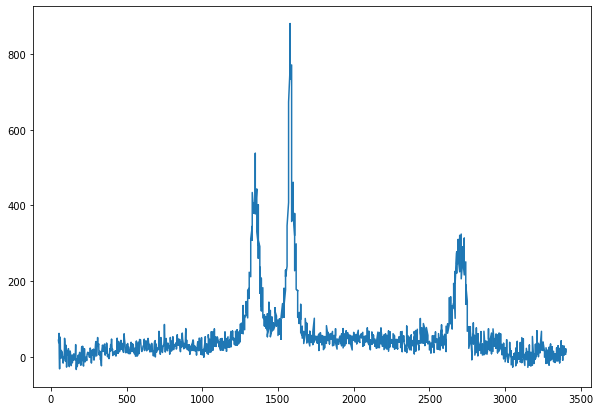

In [88]:
plots.plot(sample_spectrum.column("x"), sample_spectrum.column("y"))

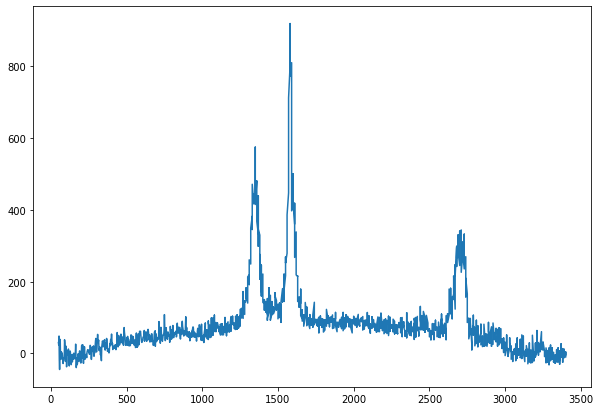

In [89]:
y_offset = sample_spectrum.apply(lambda x: -0.00002 * (x-1700)**2 + 40, "x")
new_y = sample_spectrum.column("y") + y_offset
test_spectrum = Table().with_columns("x", sample_spectrum.column("x"), "y", new_y)
sample_spectrum = test_spectrum
plots.plot(sample_spectrum.column("x"), sample_spectrum.column("y"))

In [90]:
restricted_spectrum = sample_spectrum.where("x", are.between_or_equal_to(500, min(3000, max(sample_spectrum.column("x")))))
# Smooth signal with Savitsky-Golay filter
smoothed_y = scipy.signal.savgol_filter(restricted_spectrum.column("y"), 27, 2)
smoothed_spectrum = Table().with_columns("x", restricted_spectrum.column("x"), "y", smoothed_y)

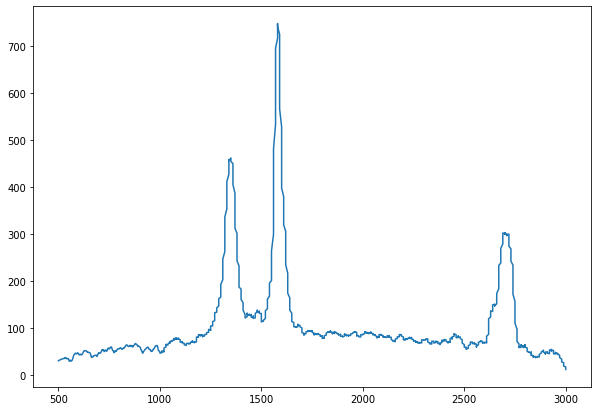

In [91]:
plots.plot(smoothed_spectrum.column("x"), smoothed_spectrum.column("y"))

In [92]:
sample_spectrum = smoothed_spectrum

inf
x    | y       | baseline
500  | 30.2582 | 25.0327
501  | 30.7722 | 25.2176
503  | 31.2594 | 25.587
505  | 31.7197 | 25.9559
507  | 32.1531 | 26.3241
509  | 32.5597 | 26.6918
511  | 32.9394 | 27.0589
513  | 33.2923 | 27.4254
515  | 33.6183 | 27.7913
517  | 33.9174 | 28.1567
... (1290 rows omitted)
spectrum rows  1001
nrows  0
inf
x    | y       | baseline
550  | 33.5744 | 32.6162
552  | 30.9592 | 32.8217
554  | 29.2889 | 33.0269
555  | 29.7042 | 33.1293
557  | 31.3065 | 33.3339
559  | 31.1611 | 33.5382
561  | 29.9727 | 33.7422
563  | 29.5848 | 33.9458
565  | 30.7169 | 34.149
567  | 31.0827 | 34.352
... (991 rows omitted)
spectrum rows  611
nrows  1001
45.726052983374835
x    | y       | baseline
552  | 30.9592 | 26.0741
554  | 29.2889 | 26.2745
555  | 29.7042 | 26.3745
557  | 31.3065 | 26.5744
559  | 31.1611 | 26.774
561  | 29.9727 | 26.9732
563  | 29.5848 | 27.1721
565  | 30.7169 | 27.3706
567  | 31.0827 | 27.5688
569  | 32.97   | 27.7667
... (601 rows omitted)
spectrum rows  277


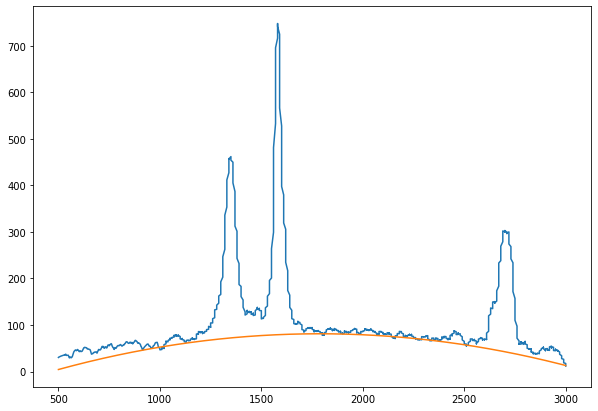

In [98]:
#y_offset = sample_spectrum.apply(lambda x: -0.00002 * (x-1700)**2 + 40, "x")
#new_y = sample_spectrum.column("y") + y_offset
#test_spectrum = Table().with_columns("x", sample_spectrum.column("x"), "y", new_y)
test_spectrum = smoothed_spectrum

kachow = baseline(test_spectrum, 2, .01)

plots.plot(sample_spectrum.column("x"), test_spectrum.column("y"))
plots.plot(sample_spectrum.column("x"), kachow)